In [29]:
using Knet, Plots, JLD, NBInclude
nbinclude("mnist.ipynb")  # loads MNIST, defines dtrn,dtst,Atype,train,softmax,zeroone
ENV["COLUMNS"]=80         # column width for array printing
plotlyjs();               # for interactive plots

## Define linear model

In [30]:
# The predict function returns a score for each class as a linear function of input x
function linear(w,x)
    y = w[1]*mat(x) .+ w[2]
end;

In [31]:
# Initialize weights as a list of [ weightMatrix, biasVector ]
winit1(;std=0.01)=map(Atype, [ std*randn(10,784), zeros(10,1) ]);

## Accuracy and zero-one loss

In [32]:
# Grab a minibatch
x,y = first(dtst)
map(summary,(x,y))

("28×28×1×100 Knet.KnetArray{Float32,4}", "100-element Array{UInt8,1}")

In [33]:
# Initialize random model and calculate predictions for one minibatch
setseed(9)           # for replicability
w = winit1()         # random weight matrix and a zero bias vector
ypred = linear(w,x)  # predict
Array(ypred)         # predictions are given as a 10xN score matrix

10×100 Array{Float32,2}:
  0.020949      0.0204775   -0.0932485   …  -0.0769949   -0.0152675
  0.0455851    -0.0707735   -0.0228169       0.00569148   0.0522016
 -0.000504205  -0.214745     0.00253635     -0.082528    -0.107451 
  0.132813     -0.103564     0.0237599       0.0487591   -0.0231088
  0.0351397    -0.0638922   -0.109847       -0.0460735   -0.100915 
 -0.0180563    -0.0725433   -0.08814     …   0.00757484  -0.13144  
  0.0370442     0.00319698  -0.0865752       0.079252     0.0637138
 -0.010542      0.0478139    0.0305943       0.107525     0.138668 
 -0.0714492    -0.124502    -0.00765008     -0.00235417   0.026818 
  0.173877      0.296371     0.0476608       0.148999     0.268136 

In [34]:
y'  # correct answers are given as an array of integers

1×100 RowVector{UInt8,Array{UInt8,1}}:
 0x07  0x02  0x01  0x0a  0x04  0x01  …  0x01  0x04  0x01  0x07  0x06  0x09

In [35]:
# accuracy gives percentage of correct answers
accuracy(ypred,y)        # 2-arg version: accuracy on this batch of 100 with initial w

0.1

In [36]:
accuracy(w,dtst,linear)  # 3-arg version: accuracy on the whole test dataset

0.0971

In [37]:
# zeroone loss (error) defined as 1 - accuracy
zeroone(w,data,model) = 1 - accuracy(w,data,model)
zeroone(w,dtst,linear)

0.9029

## Softmax loss function

In [38]:
# Calculate softmax (cross entropy, negative log likelihood) loss of a model with weights w for one minibatch (x,y)
# Predict specifies the function for model output: ypred = predict(w,x;o...)
softmax(w,x,y,predict; o...)=nll(predict(w,x;o...),y)

softmax (generic function with 2 methods)

In [39]:
# per-instance average softloss for the first test minibatch, should be close to -log(1/10)=2.3
softmax(w,x,y,linear)

2.30209f0

In [40]:
# Manual loss calculation
ypred=linear(w,x)
yp1 = exp.(ypred)
yp2 = yp1 ./ sum(yp1,1)
yp3 = -log.(yp2)
yc1 = full(sparse(y,1:100,1f0))
sum(Array(yp3).*yc1) / 100

2.30209f0

In [41]:
softmax(w,data,predict) = mean(softmax(w,x,y,predict) for (x,y) in data)
softmax(w,dtst,linear)  # per-instance average softmax loss for the whole test set

2.2936275f0

## Calculating the gradient using Knet

In [42]:
# Automatically defined gradient for softloss
softgrad = grad(softmax)  # softgrad returns gradient wrt 1st arg w

(::gradfun) (generic function with 1 method)

In [43]:
setseed(9)
w1 = winit1(std=0.1)  # use a larger std to get a larger gradient for this example

2-element Array{Knet.KnetArray{Float32,2},1}:
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Nothing} @0x000000810702d800, 31360, 0, nothing), (10, 784))
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Nothing} @0x0000008105400800, 40, 0, nothing), (10, 1))     

In [44]:
g1 = softgrad(w1,x,y,linear)  # gradient has the same size and shape as the first parameter

2-element Array{Any,1}:
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Nothing} @0x0000008107035400, 31360, 0, nothing), (10, 784))
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Nothing} @0x0000008105400a00, 40, 0, nothing), (10, 1))     

## Checking the gradient using numerical approximation

In [45]:
Array(g1[2])'  
# Meaning of gradient:
# If I move the last entry of w[2] by epsilon, loss will go up by 0.345075 epsilon!

1×10 Array{Float32,2}:
 -0.0921663  -0.00683322  -0.0612594  …  0.0736465  -0.0507283  0.345075

In [46]:
Array(w1[2])'

1×10 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [47]:
softmax(w1,x,y,linear)

2.8222036f0

In [48]:
w1[2][10] = 0.1   # to numerically check the gradient let's move the last entry by +0.1.
Array(w1[2]')

1×10 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1

In [49]:
softmax(w1,x,y,linear)  
# We see that the loss moves by +0.03 as expected.
# You should check all/most entries in your gradients this way to make sure they are correct.

2.8577392f0

## Checking the gradient using manual implementation

In [50]:
# Manually defined gradient for softloss
function softgrad_manual(w,x,y,predict)
    x = mat(x)
    p = predict(w,x)
    p = p .- maximum(p,1) # for numerical stability
    expp = exp.(p)
    p = expp ./ sum(expp,1)
    q = oftype(p, sparse(convert(Vector{Int},y),1:length(y),1,size(p,1),length(y)))
    dJdy = (p - q) / size(x,2)
    dJdw = dJdy * x'
    dJdb = sum(dJdy,2)
    Any[dJdw,dJdb]
end;

In [51]:
g2 = softgrad_manual(w1,x,y,linear)

2-element Array{Any,1}:
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Nothing} @0x000000810703d000, 31360, 0, nothing), (10, 784))
 Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Nothing} @0x0000008105400e00, 40, 0, nothing), (10, 1))     

In [52]:
g1[1] ≈ g2[1]

false

In [53]:
g1[2] ≈ g2[2]

false

## Training (SGD) loop

In [54]:
# Train model(w) with SGD and return a list containing w for every epoch
function train(w,data,predict; epochs=100,lr=0.1,o...)
    weights = Any[deepcopy(w)]
    for epoch in 1:epochs
        for (x,y) in data
            g = softgrad(w,x,y,predict;o...)
            update!(w,g,lr=lr)  # w[i] = w[i] - lr * g[i]
        end
        push!(weights,deepcopy(w))
    end
    return weights
end;

## Training the linear model and underfitting

In [55]:
if !isfile("lin.jld")
    setseed(1)
    @time weights = train(winit1(),dtrn,linear,lr=0.1)           # 31.1s
    @time trnloss = [ softmax(w,dtrn,linear) for w in weights ]  # 22.2s
    @time tstloss = [ softmax(w,dtst,linear) for w in weights ]  # 3.7s
    @time trnerr  = [ zeroone(w,dtrn,linear) for w in weights ]  # 20.6s
    @time tsterr  = [ zeroone(w,dtst,linear) for w in weights ]  # 3.4s
    @save "lin.jld" weights trnloss tstloss trnerr tsterr
else
    @eval (@load "lin.jld")
end
minimum(tstloss),minimum(tsterr)  # 0.2667, 0.0744

(0.26674008f0, 0.07440000000000002)

In [ ]:
plot([trnloss tstloss],ylim=(.2,.36),labels=[:trnloss :tstloss],xlabel="Epochs",ylabel="Loss") 
# Demonstrates underfitting: training loss not close to 0
# Also slight overfitting: test loss higher than train

In [ ]:
plot([trnerr tsterr],ylim=(.06,.10),labels=[:trnerr :tsterr],xlabel="Epochs",ylabel="Error")  
# this is the error plot, we get to about 7.5% test error, i.e. 92.5% accuracy

## Visualizing the learned weights

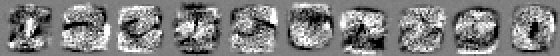

"Epoch 100"

In [56]:
for t in logspace(0,2,20)
    i = ceil(Int,t)
    w = weights[i]
    w1 = reshape(Array(w[1])', (28,28,1,10))
    w2 = clamp.(w1.+0.5,0,1)
    IJulia.clear_output(true)
    display(hcat([mnistview(w2,i) for i=1:10]...))
    display("Epoch $i")
    sleep(1) # (0.96^i)
end